In [1]:
import sys

sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

# import data.drawings.make_tasks as drawing_tasks
from src.analysis_utilities import SynthesisExperimentAnalyzer
from src.config_builder import ExperimentType

/opt/conda/envs/laps/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sns.set_theme(style="whitegrid", font_scale=1.25, rc={'figure.figsize':(12, 8)})

In [5]:
%config InlineBackend.figure_format = 'retina'

In [6]:
EXPERIMENT_NAME = "runs_multi"

COMPUTE_LIKELIHOODS = True

FIGURES_DIR = os.path.join("figures", EXPERIMENT_NAME)
os.makedirs(FIGURES_DIR, exist_ok=True)

In [7]:
analyzer = SynthesisExperimentAnalyzer(
    experiment_name=EXPERIMENT_NAME,
    experiment_types=["baseline_dreamcoder", "gpt_solver", "gpt_solver_stitch", "gpt_solver_stitch_namer", "gpt_solver_stitch_namer_hybrid_dsl", "gpt_solver_stitch_namer_search"],
    allow_incomplete_results=True,
    compute_likelihoods=COMPUTE_LIKELIHOODS,
    batch_size = 96,
    seeds = [111, 222, 333],
)

Experiment directory: ../experiments_iterative/outputs/runs_multi
Available domains: ['re2', 'clevr', 'logo']


# Tasks solved vs. LAPS iteration

In [8]:
df_results = analyzer.get_synthesis_summary()
df_results = analyzer.format_dataframe_camera(df_results)

In [9]:
df_results

,domain,Model,seed,iteration,split,n_solved,Tasks solved (%)
505,REGEX,DreamCoder,111,0,train,16,3.258656
506,REGEX,DreamCoder,111,1,train,32,6.517312
507,REGEX,DreamCoder,111,2,train,57,11.608961
509,REGEX,DreamCoder,111,3,train,77,15.682281
510,REGEX,DreamCoder,111,4,train,102,20.773931
...,...,...,...,...,...,...,...
251,CLEVR,LILO (+ Search),333,9,train,191,100.000000
238,CLEVR,LILO (+ Search),333,0,test,79,76.699029
242,CLEVR,LILO (+ Search),333,3,test,95,92.233010
246,CLEVR,LILO (+ Search),333,6,test,101,98.058252


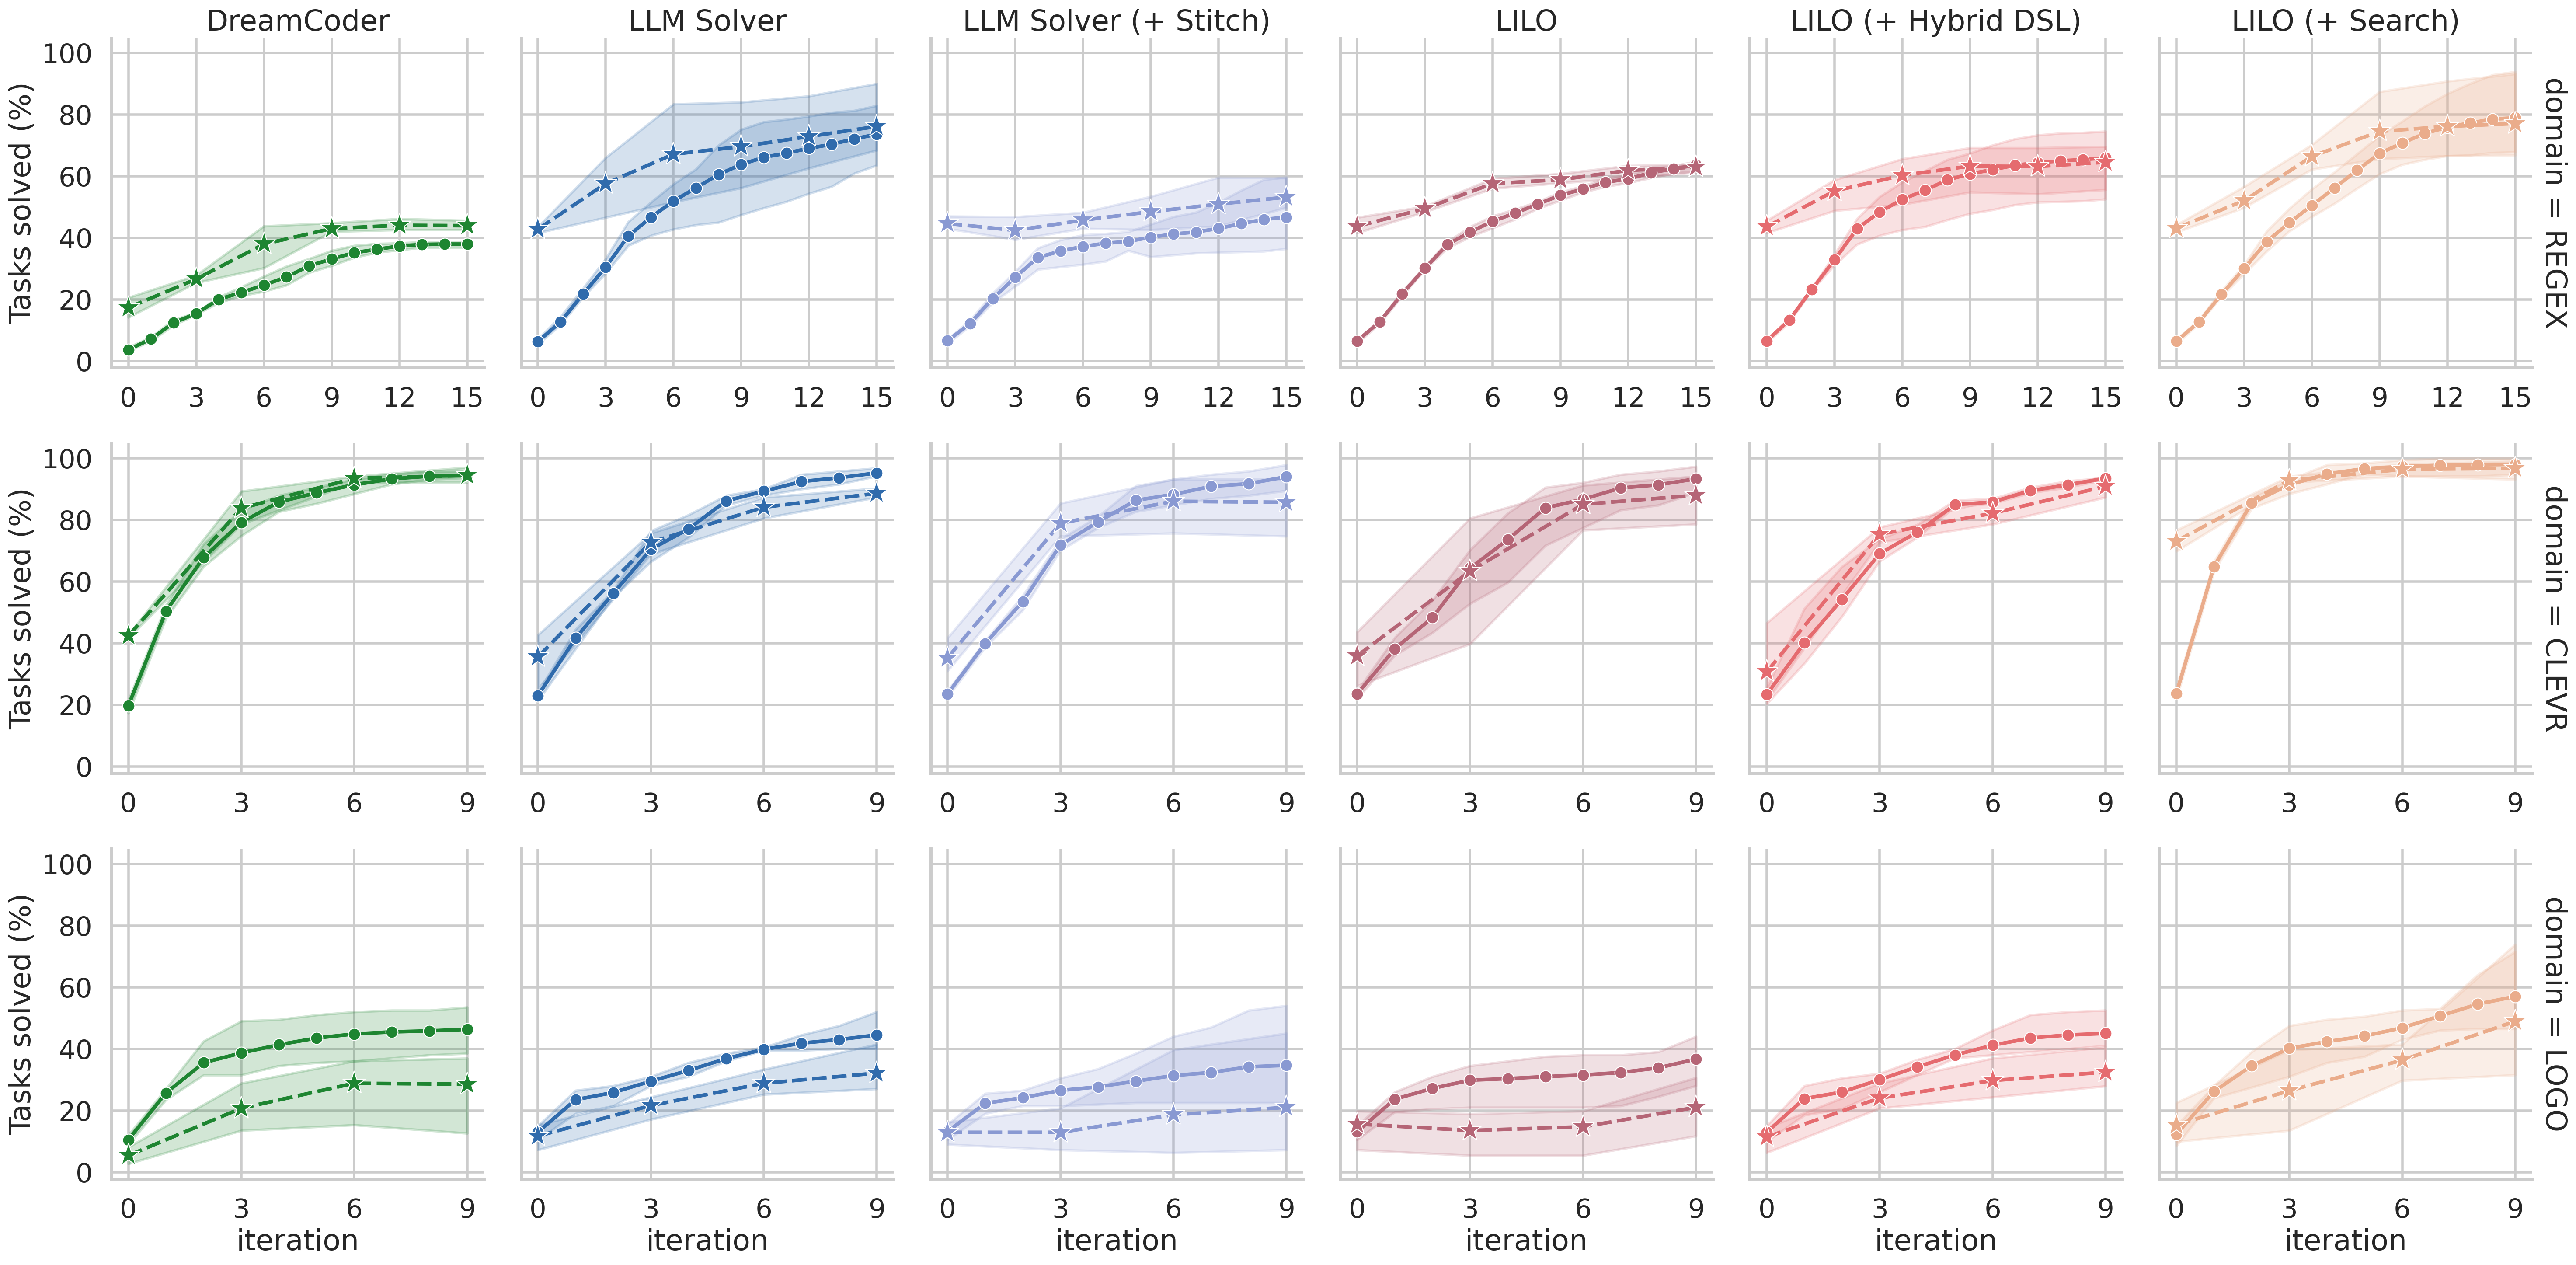

In [16]:
with sns.plotting_context("poster", font_scale=1):
    g = sns.relplot(
        data=df_results,
        kind="line",
        row="domain",
        col=analyzer.COL_NAMES_CAMERA["experiment_type"],
        x="iteration",
        y=analyzer.COL_NAMES_CAMERA["percent_solved"],
        hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
        style="split",
        markers=[".", "*"],
        markersize=20,
        # errorbar="se",
        # col_order=["train", "test"],
        row_order = list(analyzer.DOMAIN_NAMES_CAMERA.values()),
        facet_kws={'sharex': False, 'sharey': True, 'margin_titles': True},
        palette=analyzer.EXPERIMENT_TYPES_PALETTE,
        legend=False,
    )
    for subplot in g.axes[0]:
        subplot.set_title(subplot.title.get_text().split(" = ")[-1])
        
    for ax in g.axes[0]:
        ax.set_xticks(np.arange(0, 16, 3))
    for ax in g.axes[1]:
        ax.set_xticks(np.arange(0, 10, 3))
    for ax in g.axes[2]:
        ax.set_xticks(np.arange(0, 10, 3))
        
    # sns.move_legend(g, "lower center")
        
    plt.savefig(os.path.join(FIGURES_DIR, "main_results.pdf"), dpi=300, bbox_inches="tight")

# Main results table

In [11]:
df_results_test = df_results.query("split == 'test'")
grouped = df_results_test.groupby([
    "domain",
    analyzer.COL_NAMES_CAMERA["experiment_type"],
    "seed",
], as_index=False)

def _get_final_iteration(group):
    final_iteration = group["iteration"].max().item()
    return group[group["iteration"] == final_iteration]

df_results_test = grouped.apply(_get_final_iteration).reset_index(drop=True)
df_results_test

,domain,Model,seed,iteration,split,n_solved,Tasks solved (%)
0,CLEVR,DreamCoder,111,9,test,100,97.087379
1,CLEVR,DreamCoder,222,9,test,97,94.174757
2,CLEVR,DreamCoder,333,9,test,95,92.233010
3,CLEVR,LILO,111,9,test,81,78.640777
4,CLEVR,LILO,222,9,test,97,94.174757
5,CLEVR,LILO,333,9,test,94,91.262136
6,CLEVR,LILO (+ Hybrid DSL),111,9,test,94,91.262136
7,CLEVR,LILO (+ Hybrid DSL),222,9,test,90,87.378641
8,CLEVR,LILO (+ Hybrid DSL),333,9,test,97,94.174757
9,CLEVR,LILO (+ Search),111,9,test,96,93.203883


In [17]:
df_metrics_test = df_results_test.groupby([
    "domain",
    analyzer.COL_NAMES_CAMERA["experiment_type"],
]) \
[[
    analyzer.COL_NAMES_CAMERA["percent_solved"]
]] \
.agg(["mean", "max", "std"])

df_metrics_test = df_metrics_test.reindex(list(analyzer.DOMAIN_NAMES_CAMERA.values()), level=0)
df_metrics_test

Tasks solved (%)                      
                                         mean        max        std
domain Model                                                       
REGEX  DreamCoder                   43.933333  45.600000   1.527525
       LILO                         62.933333  63.800000   1.501111
       LILO (+ Hybrid DSL)          64.533333  69.600000   7.759725
       LILO (+ Search)              77.066667  93.200000  14.144021
       LLM Solver                   76.133333  90.000000  12.035503
       LLM Solver (+ Stitch)        53.200000  59.400000   5.377732
CLEVR  DreamCoder                   94.498382  97.087379   2.443312
       LILO                         88.025890  94.174757   8.257185
       LILO (+ Hybrid DSL)          90.938511  94.174757   3.409597
       LILO (+ Search)              96.763754  99.029126   3.120923
       LLM Solver                   88.673139  90.291262   1.483034
       LLM Solver (+ Stitch)        85.760518  93.203883   9.724906
LOGO   DreamCoder                   28.528529  36.936937  13.790946
       LILO                         21.021021  30.630631   9.463034
       LILO (+ Hybrid DSL)          32.432432  40.540541   7.036261
       LILO (+ Search)              48.948949  73.873874  22.147020
       LLM Solver                   32.132132  41.441441   8.074672
       LLM Solver (+ Stitch)        21.021021  45.045045  20.883290

In [18]:
# Reorder column levels
df_metrics_test_final = df_metrics_test.reset_index().pivot(index="Model", columns="domain").reorder_levels(order=[0, 2, 1], axis="columns")

# Reorder columns
multiindex = df_metrics_test_final.columns
multiindex = multiindex.reindex(list(analyzer.DOMAIN_NAMES_CAMERA.values()), level=1)[0]
multiindex = multiindex.reindex(["max", "mean", "std"], level=2)[0]

df_metrics_test_final = df_metrics_test_final.reindex(columns=multiindex)
df_metrics_test_final.columns.names = [None, None, None]

# Reorder rows
experiment_types = [x for x in analyzer.EXPERIMENT_TYPES_CAMERA.values() if x in df_metrics_test_final.index]
df_metrics_test_final = df_metrics_test_final.reindex(experiment_types)

# Remove 'Model'
df_metrics_test_final.index.name = None

# Round numbers
df_metrics_test_final = df_metrics_test_final.round(2)

# Output to LaTeX
df_metrics_test_final.to_latex("main_results_table.tex")

df_metrics_test_final

Tasks solved (%)                                    \
                                 REGEX                CLEVR                
                                   max   mean    std    max   mean   std   
DreamCoder                        45.6  43.93   1.53  97.09  94.50  2.44   
LLM Solver                        90.0  76.13  12.04  90.29  88.67  1.48   
LLM Solver (+ Stitch)             59.4  53.20   5.38  93.20  85.76  9.72   
LILO                              63.8  62.93   1.50  94.17  88.03  8.26   
LILO (+ Hybrid DSL)               69.6  64.53   7.76  94.17  90.94  3.41   
LILO (+ Search)                   93.2  77.07  14.14  99.03  96.76  3.12   

                                            
                        LOGO                
                         max   mean    std  
DreamCoder             36.94  28.53  13.79  
LLM Solver             41.44  32.13   8.07  
LLM Solver (+ Stitch)  45.05  21.02  20.88  
LILO                   30.63  21.02   9.46  
LILO (+ Hybrid DSL)    40.54  32.43   7.04  
LILO (+ Search)        73.87  48.95  22.15

# Runtime metrics

In [ ]:
df_runtime = analyzer.get_runtime_metrics()
df_runtime.groupby(["domain", "experiment_type", "model_type", "model_fn", "task_split"]).time_elapsed.agg("mean")

In [ ]:
df_infer_programs = df_runtime.query("model_fn == 'infer_programs_for_tasks'").query("model_type != 'grammar'")
df_infer_programs

In [ ]:
analyzer.format_dataframe_camera(df_infer_programs)

In [ ]:
sns.catplot(
    data=analyzer.format_dataframe_camera(df_infer_programs), 
    kind="bar",
    col="domain",
    row="task_split",
    sharex=False, 
    y="model_type",
    x="time_elapsed", 
    hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
    palette=analyzer.EXPERIMENT_TYPES_PALETTE,
    margin_titles=True,
)

In [ ]:
sns.catplot(
    data=analyzer.format_dataframe_camera(df_infer_programs), 
    kind="strip",
    col="domain",
    row="model_type",
    sharex=False, 
    sharey=False,
    y="task_split",
    x="time_elapsed", 
    hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
    palette=analyzer.EXPERIMENT_TYPES_PALETTE,
    margin_titles=True,
)

In [ ]:
sns.catplot(
    data=analyzer.format_dataframe_camera(df_infer_programs), 
    kind="strip",
    col="model_type",
    row="domain",
    sharex=True,
    # sharey=False,
    y="task_split",
    x="time_elapsed", 
    hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
    palette=analyzer.EXPERIMENT_TYPES_PALETTE,
    margin_titles=True,
)